In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
    num_paral_jobs = 8
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
    num_paral_jobs = 12
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.3.1
pandas 1.2.4
h5py 2.10.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.2


# Neuropixels data.

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Donload time: 288000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

In [5]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

#### Fine Time Coupling Model

In [6]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)

#### Trials Selection

In [10]:
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
condition_ids = [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  247 temp freq [2.0] orient [180.0] contrast [0.8] [ 3799  3827  3847  3874  3883  3887  3908  3939 31059 31111 31115 49278 49348 49387 49396]
1  248 temp freq [1.0] orient [45.0] contrast [0.8] [ 3800  3807  3820  3853  3907  3975  3993 31013 31036 31091 31106 31120 31127 49216 49397]
2  250 temp freq [2.0] orient [270.0] contrast [0.8] [ 3802  3903  3991 31006 31109 31136 49229 49267 49273 49300 49308 49363 49369 49379 49382]
3  251 temp freq [1.0] orient [90.0] contrast [0.8] [ 3803  3806  3885  3890  3983 31017 31052 31131 31132 49224 49334 49345 49351 49373 49384]
4  252 temp freq [1.0] orient [0.0] contrast [0.8] [ 3804  3869  3873  3916 31037 31050 31061 31157 31193 49271 49279 49309 49404 49417 49429]
5  253 temp freq [1.0] orient [315.0] contrast [0.8] [ 3805  3812  3843  3850  3857  3952  3994 31008 31029 31163 31181 49269 49289 49338 49419]
6  254 temp freq [15.0] orient [180.0] contrast [0.8] [ 3808  3837  3856  3858  3879 31011 31019 31049 31118 31155 49208 49244 49291 4

## Spike Trains

In [8]:
trial_window = [0.4, 2.0]
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


In [11]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(261, 315)

# Trial-wise cluster, joint-trial filter fit.

In [24]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 247), (1, 248), (2, 250), (3, 251), (4, 252), (5, 253), (6, 254), (7, 255), (8, 259), (9, 262), (10, 264), (11, 266), (12, 269), (13, 271), (14, 272), (15, 276), (16, 277), (17, 279), (18, 282), (19, 283), (20, 285)]


In [25]:
# select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
select_condition_ids = [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3799  3800  3802  3803  3804  3805  3806  3807  3808  3809  3812  3815  3818  3820  3821  3823  3825  3827
  3830  3832  3834  3836  3837  3838  3839  3840  3842  3843  3846  3847  3849  3850  3851  3853  3856  3857
  3858  3861  3863  3864  3865  3867  3868  3869  3871  3873  3874  3877  3879  3883  3885  3887  3890  3891
  3893  3896  3901  3902  3903  3907  3908  3909  3910  3913  3915  3916  3918  3919  3926  3927  3929  3931
  3935  3939  3940  3941  3945  3950  3952  3954  3957  3961  3963  3965  3969  3970  3971  3972  3974  3975
  3977  3978  3982  3983  3985  3990  3991  3993  3994 31001 31005 31006 31008 31009 31010 31011 31012 31013
 31017 31018 31019 31023 31025 31029 31032 31036 31037 31038 31041 31042 31044 31045 31049 31050 31052 31057
 31059 31060 31061 31063 31065 31067 31068 31069 31070 31073 31074 31082 31083 31084 31087 31088 31090 31091
 31094 31095 31097 31099 31100 31101 31102 31103 31106 31107 31109 31110 31111 31113 31115 31117 31118 31119
 31120 31121 31122 

/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

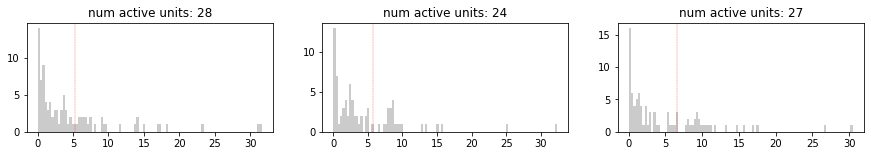

num_pairs: 672
num_pairs: 648
filter_membership.shape (672, 315)
membership cnt [(0, 211680)]
filter_membership.shape (648, 315)
membership cnt [(0, 204120)]
filter_membership.shape (1320, 315)
membership cnt [(0, 415800)]


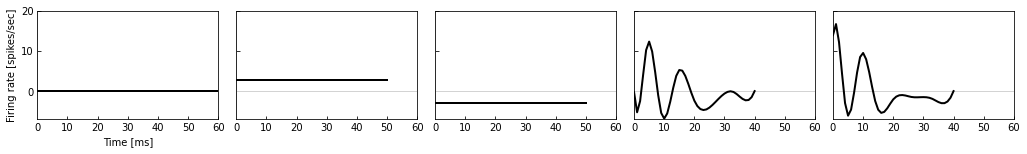

In [27]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr149_20210523-070711.pkl'
# filter_membership_CD = util.load_variable(file_path)
# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr149_20210523-070711.pkl'
# filter_membership_DE = util.load_variable(file_path)
filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
model.filter_membership_statistics(filter_membership_CD, verbose=True)
model.filter_membership_statistics(filter_membership_DE, verbose=True)
model.filter_membership_statistics(filter_membership_joint, verbose=True)
group_portion = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/group_model_pars_joint_itr149_20210523-071613.pkl'
group_model_pars = util.load_variable(file_path)
group_model_pars[2]['beta'][2] = -3  # TMP manual modification.
model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5])

#### Estimate optimal kernel width (plug-in estimator)

#all trials:415800	#batch trials:1000
optimal kernel width  55.0


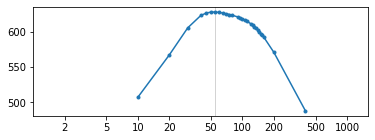

In [22]:
model.estimate_nuisance_kernel_width_together(filter_membership_joint, batch_size=1000)

### Parallel programming.

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 40807), (1, 42707), (2, 50913), (3, 41425), (4, 35828)]
filter_membership.shape (648, 315)
membership cnt [(0, 35685), (1, 41441), (2, 51211), (3, 40023), (4, 35760)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr0_20211127_190950.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr0_20211127_190950.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr0_20211127_190950.pkl
filter_membership.shape (1320, 315)
#all trials:84148	#batch trials:84148
X.shape (1586406, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.691e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:71588	#batch trials:71588
X.shape (1624267, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.41it/s]
num itr 59 [[-2726500.41665542]] 0.021910177970051195
beta [ 1.38487897e+01  2.04025881e-02  1.40290156e+01  2.42610609e+01 -2.23163145e+01  2.18414317e+01
 -9.95573991e+00  6.28289797e-01 -1.18180981e+00 -7.71773887e-01 -3.35969317e+00]
gradient [-2.52460761 71.85421698 -3.00790907 -2.96982484 -0.7067482  -3.02541298  0.28891945  2.01858334  1.18167586
  1.3767392   1.02489145]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.191e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


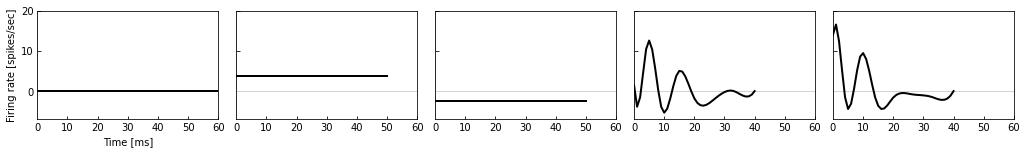

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr0_20211127_192846.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 44957), (1, 44504), (2, 51966), (3, 35586), (4, 34667)]
filter_membership.shape (648, 315)
membership cnt [(0, 38743), (1, 42099), (2, 53018), (3, 35419), (4, 34841)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr1_20211127_194021.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr1_20211127_194021.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr1_20211127_194021.pkl
filter_membership.shape (1320, 315)
#all trials:86603	#batch trials:86603
X.shape (1546860, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.968e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:69508	#batch trials:69508
X.shape (1592056, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.50it/s]
num itr 59 [[-2689483.05127604]] 0.023374865967972235
beta [ 1.38532922e+01  1.86577793e-02  1.45401318e+01  2.57553448e+01 -2.22251492e+01  2.23498052e+01
 -9.84681973e+00  4.33457708e-01 -7.81230175e-01 -5.04658750e-01 -3.28101568e+00]
gradient [-2.7402707  22.82172663 -3.06728613 -3.33982744 -1.32711807 -3.3436481  -0.39762391  1.31092907 -0.32029093
 -0.07444547  0.42522193]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.337e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


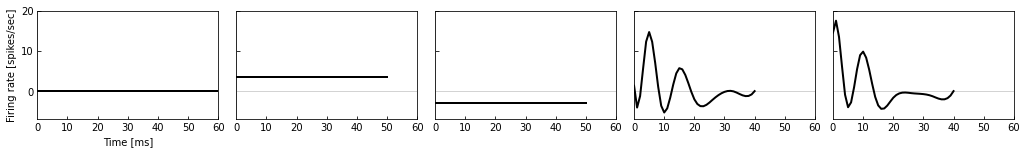

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr1_20211127_195912.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 46242), (1, 42550), (2, 54623), (3, 34483), (4, 33782)]
filter_membership.shape (648, 315)
membership cnt [(0, 40045), (1, 40609), (2, 54818), (3, 34414), (4, 34234)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr2_20211127_201047.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr2_20211127_201047.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr2_20211127_201047.pkl
filter_membership.shape (1320, 315)
#all trials:83159	#batch trials:83159
X.shape (1501612, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:1.909e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:68016	#batch trials:68016
X.shape (1565209, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.64it/s]
num itr 59 [[-2653011.18187946]] 0.024821497977901022
beta [ 1.38390548e+01  1.03668250e-02  1.49326949e+01  2.71642921e+01 -2.25590439e+01  2.30879584e+01
 -1.00183099e+01  4.80432822e-01 -7.21053178e-01 -2.89002744e-01 -3.31162324e+00]
gradient [-1.89288851 75.44454961 -3.09772899 -3.3271087  -1.03266286 -3.1367526   0.35959795  2.09367902  0.95048806
  0.96640022  1.00678098]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.482e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


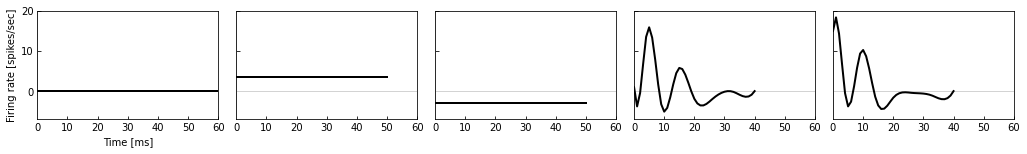

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr2_20211127_202923.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 46753), (1, 42711), (2, 55105), (3, 33765), (4, 33346)]
filter_membership.shape (648, 315)
membership cnt [(0, 40483), (1, 40864), (2, 55451), (3, 33619), (4, 33703)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr3_20211127_204055.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr3_20211127_204055.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr3_20211127_204055.pkl
filter_membership.shape (1320, 315)
#all trials:83575	#batch trials:83575
X.shape (1494068, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.265e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:67049	#batch trials:67049
X.shape (1544859, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]
num itr 59 [[-2621141.4514794]] 0.02546985824975908
beta [ 1.38250854e+01  7.04201307e-03  1.51275520e+01  2.77338891e+01 -2.27316848e+01  2.34185956e+01
 -1.01210551e+01  5.46537770e-01 -7.37336281e-01 -1.43096239e-01 -3.34150909e+00]
gradient [-1.82465581 75.92394579 -3.0860706  -3.3371349  -1.05187115 -3.1300675   0.37216258  2.09269564  0.9765852
  0.9708824   1.00634404]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.547e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


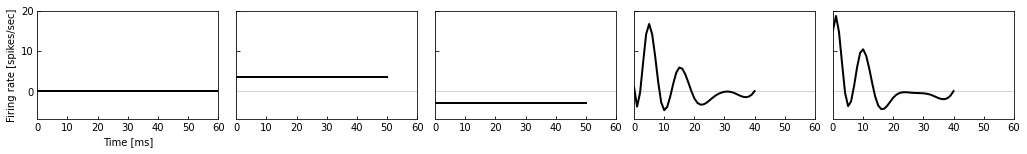

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr3_20211127_205929.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47211), (1, 42592), (2, 55797), (3, 33057), (4, 33023)]
filter_membership.shape (648, 315)
membership cnt [(0, 40797), (1, 40668), (2, 56151), (3, 33015), (4, 33489)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr4_20211127_211102.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr4_20211127_211102.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr4_20211127_211102.pkl
filter_membership.shape (1320, 315)
#all trials:83260	#batch trials:83260
X.shape (1487579, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.027e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66512	#batch trials:66512
X.shape (1533792, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.74it/s]
num itr 59 [[-2603943.94587859]] 0.025690999110982504
beta [ 1.38250765e+01  5.27411572e-03  1.51569659e+01  2.80400088e+01 -2.28866774e+01  2.35178786e+01
 -1.01400858e+01  5.74224028e-01 -7.83743406e-01  7.55459387e-03 -3.37490823e+00]
gradient [-1.8172622  77.06091537 -3.07433134 -3.33470491 -1.03977929 -3.09836849  0.37494093  2.08990362  0.9821113
  0.95268077  0.99499896]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.569e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


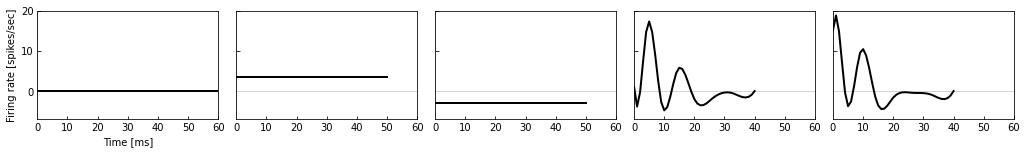

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr4_20211127_212928.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47485), (1, 42855), (2, 55765), (3, 32785), (4, 32790)]
filter_membership.shape (648, 315)
membership cnt [(0, 41169), (1, 40794), (2, 56105), (3, 32769), (4, 33283)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr5_20211127_214103.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr5_20211127_214103.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr5_20211127_214103.pkl
filter_membership.shape (1320, 315)
#all trials:83649	#batch trials:83649
X.shape (1493558, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.245e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66073	#batch trials:66073
X.shape (1524658, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.56it/s]
num itr 59 [[-2589673.80104832]] 0.025960640032322804
beta [ 1.38347396e+01  6.80950308e-03  1.51259378e+01  2.83374828e+01 -2.31845854e+01  2.36883672e+01
 -1.02330016e+01  6.20571191e-01 -8.71445191e-01  1.31284524e-01 -3.42718267e+00]
gradient [-1.74024617 75.23021537 -3.06238952 -3.32449958 -1.01076268 -3.07710894  0.38603497  2.09446808  1.00683444
  0.9554495   0.99408597]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.596e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


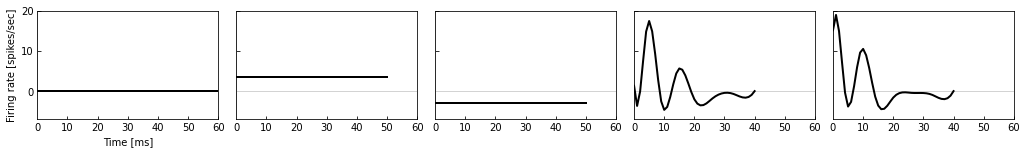

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr5_20211127_215927.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47485), (1, 43023), (2, 55771), (3, 32709), (4, 32692)]
filter_membership.shape (648, 315)
membership cnt [(0, 41196), (1, 40861), (2, 56224), (3, 32664), (4, 33175)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr6_20211127_221101.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr6_20211127_221101.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr6_20211127_221101.pkl
filter_membership.shape (1320, 315)
#all trials:83884	#batch trials:83884
X.shape (1497735, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.092e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:65867	#batch trials:65867
X.shape (1520397, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.75it/s]
num itr 59 [[-2582796.17457947]] 0.025782494589261684
beta [ 1.38382417e+01  5.22586349e-03  1.50224669e+01  2.84178600e+01 -2.32871230e+01  2.36213190e+01
 -1.01878673e+01  6.28324137e-01 -8.91183766e-01  2.49358879e-01 -3.45048414e+00]
gradient [-1.78562617 77.14227244 -3.04490537 -3.30643418 -0.97785155 -3.02919052  0.38211947  2.0836584   0.98570003
  0.92367665  0.98067248]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.578e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


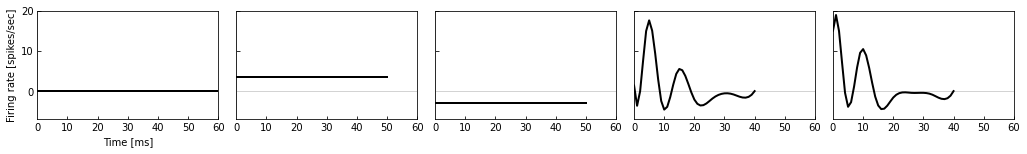

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr6_20211127_222938.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47449), (1, 43020), (2, 55770), (3, 32635), (4, 32806)]
filter_membership.shape (648, 315)
membership cnt [(0, 41233), (1, 41080), (2, 55964), (3, 32601), (4, 33242)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr7_20211127_224114.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr7_20211127_224114.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr7_20211127_224114.pkl
filter_membership.shape (1320, 315)
#all trials:84100	#batch trials:84100
X.shape (1501273, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.084e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66048	#batch trials:66048
X.shape (1521093, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]
num itr 59 [[-2580524.73199742]] 0.025640986060752248
beta [ 1.38073664e+01  5.01578092e-03  1.49145751e+01  2.84739309e+01 -2.33935917e+01  2.35762174e+01
 -1.01482947e+01  6.26724827e-01 -9.09676881e-01  3.35049539e-01 -3.47815372e+00]
gradient [-1.80126093 78.26651238 -3.0509383  -3.3129225  -0.95375169 -3.01680613  0.38105283  2.09179507  0.98660154
  0.91542401  0.98215495]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.564e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


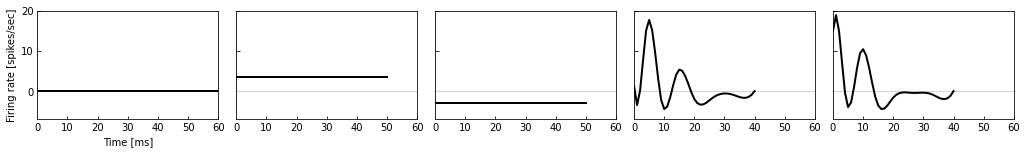

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr7_20211127_225932.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.7min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47805), (1, 42989), (2, 55869), (3, 32407), (4, 32610)]
filter_membership.shape (648, 315)
membership cnt [(0, 41576), (1, 40932), (2, 56157), (3, 32321), (4, 33134)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr8_20211127_231104.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr8_20211127_231104.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr8_20211127_231104.pkl
filter_membership.shape (1320, 315)
#all trials:83921	#batch trials:83921
X.shape (1499442, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.149e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:65744	#batch trials:65744
X.shape (1513673, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.82it/s]
num itr 59 [[-2567532.67772396]] 0.025567543565012566
beta [ 1.38055667e+01  5.39879217e-03  1.48995077e+01  2.85320396e+01 -2.35838245e+01  2.35990508e+01
 -1.01290311e+01  6.44011071e-01 -9.55813554e-01  4.27546024e-01 -3.51296998e+00]
gradient [-1.77614392 78.55668814 -3.03973104 -3.28726293 -0.90970112 -2.98717826  0.37545486  2.08750451  0.99802098
  0.91420468  0.98150659]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.557e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


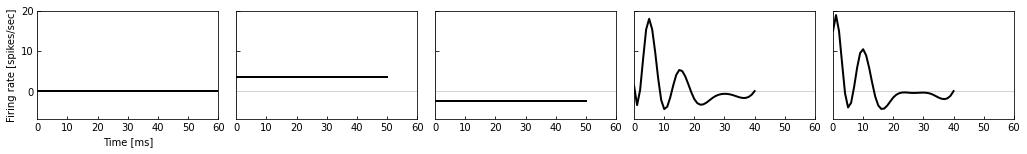

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr8_20211127_232923.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 46700), (1, 43505), (2, 55467), (3, 32827), (4, 33181)]
filter_membership.shape (648, 315)
membership cnt [(0, 40276), (1, 41388), (2, 56101), (3, 32824), (4, 33531)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr9_20211127_234057.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr9_20211127_234057.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr9_20211127_234057.pkl
filter_membership.shape (1320, 315)
#all trials:84893	#batch trials:84893
X.shape (1505149, 3), basis_integral.shape (3, 1),beta

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.456e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66712	#batch trials:66712
X.shape (1533244, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.61it/s]
num itr 59 [[-2597787.7745064]] 0.02530545391578331
beta [ 1.37991495e+01  7.52790757e-03  1.48088371e+01  2.84482041e+01 -2.37046211e+01  2.34867056e+01
 -1.00753376e+01  6.12497110e-01 -1.01092661e+00  4.99476442e-01 -3.58085570e+00]
gradient [-1.82508443 76.21575905 -3.06605215 -3.30874871 -0.89345154 -2.99845189  0.34759644  2.08735121  0.97137094
  0.88044833  0.9727076 ]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.531e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


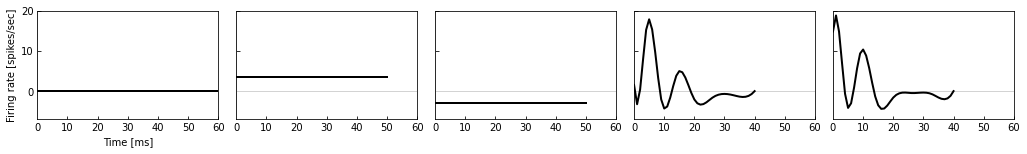

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr9_20211127_235925.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47519), (1, 43177), (2, 55908), (3, 32240), (4, 32836)]
filter_membership.shape (648, 315)
membership cnt [(0, 41241), (1, 41236), (2, 56150), (3, 32250), (4, 33243)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr10_20211128_001059.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr10_20211128_001059.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr10_20211128_001059.pkl
filter_membership.shape (1320, 315)
#all trials:84413	#batch trials:84413
X.shape (1504850, 3), basis_integral.shape (3, 1),b

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.415e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66079	#batch trials:66079
X.shape (1518062, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.77it/s]
num itr 59 [[-2571450.20320008]] 0.025054908715413868
beta [ 1.37916361e+01  6.62475006e-03  1.47889981e+01  2.84718187e+01 -2.38122582e+01  2.34280368e+01
 -1.00058285e+01  6.11321901e-01 -1.01526988e+00  5.63393296e-01 -3.58964488e+00]
gradient [-1.8314449  78.01994257 -3.04388634 -3.27328625 -0.84863589 -2.9474148   0.33661286  2.07013877  0.97369099
  0.87751065  0.96875499]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.505e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


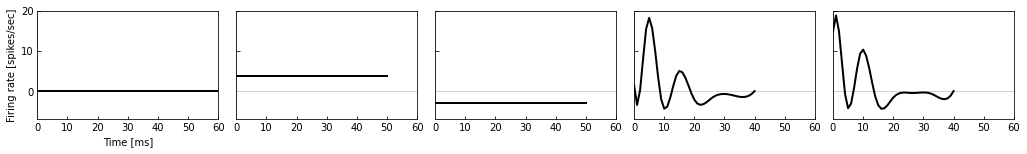

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr10_20211128_002957.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 48081), (1, 43151), (2, 55806), (3, 32011), (4, 32631)]
filter_membership.shape (648, 315)
membership cnt [(0, 41716), (1, 41125), (2, 56198), (3, 32050), (4, 33031)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr11_20211128_004132.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr11_20211128_004132.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr11_20211128_004132.pkl
filter_membership.shape (1320, 315)
#all trials:84276	#batch trials:84276
X.shape (1504494, 3), basis_integral.shape (3, 1),b

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.211e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:65662	#batch trials:65662
X.shape (1511486, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.84it/s]
num itr 59 [[-2563329.79737619]] 0.02509892770655646
beta [ 1.38208775e+01  7.28369226e-03  1.48473867e+01  2.85690230e+01 -2.40004912e+01  2.34898980e+01
 -9.98441058e+00  6.24669045e-01 -1.07600715e+00  6.41568184e-01 -3.64924226e+00]
gradient [-1.77226425 78.34969267 -3.03305578 -3.24562647 -0.80815018 -2.91738106  0.34150181  2.07594713  1.01567568
  0.90580872  0.98244472]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.510e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


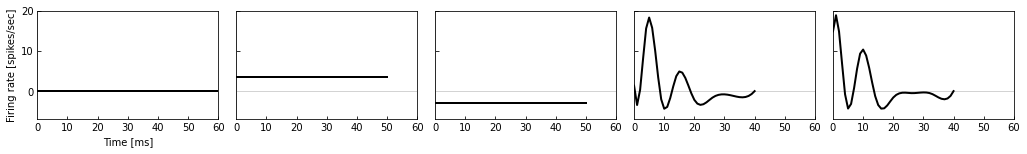

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr11_20211128_005958.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47703), (1, 43174), (2, 55850), (3, 32183), (4, 32770)]
filter_membership.shape (648, 315)
membership cnt [(0, 41470), (1, 41155), (2, 56163), (3, 32165), (4, 33167)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr12_20211128_011134.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr12_20211128_011134.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr12_20211128_011134.pkl
filter_membership.shape (1320, 315)
#all trials:84329	#batch trials:84329
X.shape (1507815, 3), basis_integral.shape (3, 1),b

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.222e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:65937	#batch trials:65937
X.shape (1515243, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.75it/s]
num itr 59 [[-2567124.90290303]] 0.0250761880029083
beta [ 1.37931224e+01  6.28402696e-03  1.49353168e+01  2.84900912e+01 -2.40090200e+01  2.34527657e+01
 -9.89531561e+00  6.53357967e-01 -1.13958427e+00  7.36822875e-01 -3.67655030e+00]
gradient [-1.79809613 79.09538254 -3.05063084 -3.24975694 -0.79606371 -2.92874016  0.30970934  2.07085885  1.01750552
  0.89228409  0.97952463]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.508e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


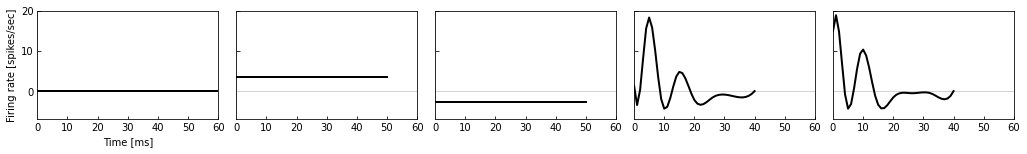

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr12_20211128_012951.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47158), (1, 43488), (2, 55667), (3, 32413), (4, 32954)]
filter_membership.shape (648, 315)
membership cnt [(0, 40907), (1, 41300), (2, 56238), (3, 32375), (4, 33300)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr13_20211128_014128.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr13_20211128_014128.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr13_20211128_014128.pkl
filter_membership.shape (1320, 315)
#all trials:84788	#batch trials:84788
X.shape (1510863, 3), basis_integral.shape (3, 1),b

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.196e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66254	#batch trials:66254
X.shape (1522149, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.76it/s]
num itr 59 [[-2578401.24760508]] 0.0249702357646999
beta [ 1.37950019e+01  7.03024003e-03  1.49882858e+01  2.84404715e+01 -2.40825202e+01  2.34270088e+01
 -9.84135099e+00  6.53637384e-01 -1.21903042e+00  8.31940155e-01 -3.73939916e+00]
gradient [-1.80762915 78.69750025 -3.06648345 -3.2544009  -0.78037971 -2.93434596  0.28654887  2.07386185  1.03318272
  0.89286837  0.98324476]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.497e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


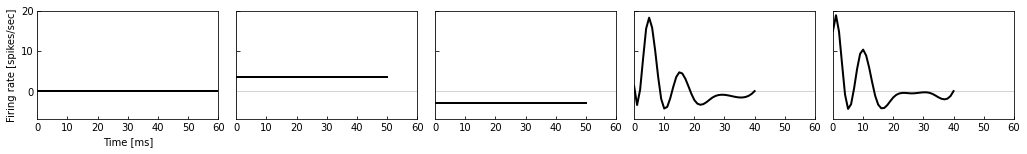

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr13_20211128_015952.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47417), (1, 43307), (2, 55867), (3, 32251), (4, 32838)]
filter_membership.shape (648, 315)
membership cnt [(0, 41198), (1, 41278), (2, 56129), (3, 32249), (4, 33266)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr14_20211128_021127.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr14_20211128_021127.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr14_20211128_021127.pkl
filter_membership.shape (1320, 315)
#all trials:84585	#batch trials:84585
X.shape (1511927, 3), basis_integral.shape (3, 1),b

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.299e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66104	#batch trials:66104
X.shape (1517311, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]
num itr 59 [[-2568780.83701818]] 0.024897942796020124
beta [ 1.37773153e+01  5.37042706e-03  1.50664330e+01  2.83328849e+01 -2.40626463e+01  2.33529503e+01
 -9.71128080e+00  6.42450590e-01 -1.25335462e+00  9.21871168e-01 -3.76821059e+00]
gradient [-1.83355856 80.49011287 -3.06563569 -3.23472358 -0.75573912 -2.92174473  0.26231018  2.06805091  1.04770324
  0.89701093  0.98286231]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.490e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


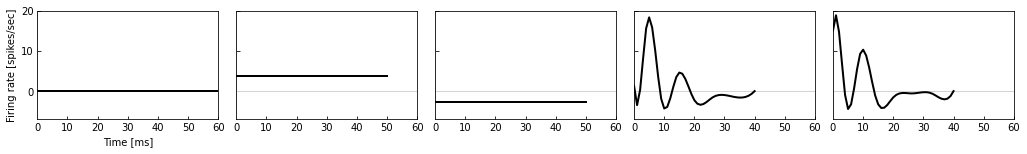

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr14_20211128_023004.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47667), (1, 43622), (2, 55602), (3, 32109), (4, 32680)]
filter_membership.shape (648, 315)
membership cnt [(0, 41351), (1, 41411), (2, 56043), (3, 32197), (4, 33118)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr15_20211128_024139.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr15_20211128_024139.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr15_20211128_024139.pkl
filter_membership.shape (1320, 315)
#all trials:85033	#batch trials:85033
X.shape (1513117, 3), basis_integral.shape (3, 1),b

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.333e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:65798	#batch trials:65798
X.shape (1514098, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.75it/s]
num itr 59 [[-2567240.94306001]] 0.02496687102012847
beta [ 1.38228891e+01  8.18108837e-03  1.52004638e+01  2.84454922e+01 -2.42609353e+01  2.34271185e+01
 -9.74388571e+00  6.51138296e-01 -1.36573435e+00  1.00879442e+00 -3.86800039e+00]
gradient [-1.76158745 77.67840698 -3.06364723 -3.22186981 -0.73273505 -2.89945125  0.25801889  2.06753527  1.07284984
  0.89940503  0.98805111]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.497e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


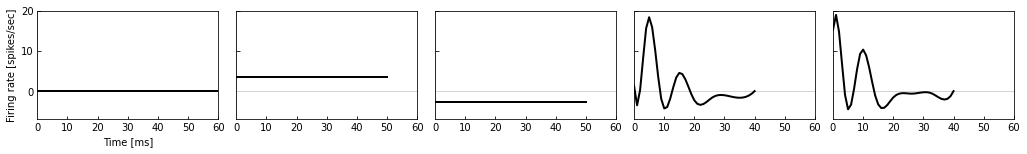

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr15_20211128_025959.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   40.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished


filter_membership.shape (672, 315)
membership cnt [(0, 47243), (1, 43433), (2, 55708), (3, 32396), (4, 32900)]
filter_membership.shape (648, 315)
membership cnt [(0, 40906), (1, 41419), (2, 56132), (3, 32352), (4, 33311)]
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_CD_itr16_20211128_031137.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/filter_membership_DE_itr16_20211128_031137.pkl
util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_portion_itr16_20211128_031137.pkl
filter_membership.shape (1320, 315)
#all trials:84852	#batch trials:84852
X.shape (1515763, 3), basis_integral.shape (3, 1),b

/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.367e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


#all trials:66211	#batch trials:66211
X.shape (1521257, 11), basis_integral.shape (11, 1),beta.shape(11, 1)
100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]
num itr 59 [[-2577020.08915151]] 0.024940924514052713
beta [ 1.37975744e+01  7.34095463e-03  1.52500508e+01  2.83865103e+01 -2.42341282e+01  2.34006106e+01
 -9.67278216e+00  6.75194869e-01 -1.44095880e+00  1.11718532e+00 -3.91245812e+00]
gradient [-1.77856779 78.79392529 -3.08525019 -3.2360206  -0.72990193 -2.92171906  0.23880994  2.07809931  1.09898033
  0.90883873  0.99486508]
Finish 4.


/home/yuchen/workspace/Brain_Network/Code/jitter.py:4090: UserWarning: Reach max itrs 60. Last err:2.494e-02
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


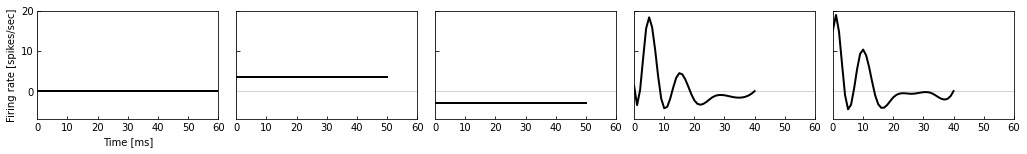

util.save_variable, save variable to:  /home/yuchen/workspace/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/group_model_pars_joint_itr16_20211128_032950.pkl


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 315 out of 315 | elapsed:  5.8min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
ERROR:concurrent.futures:exception calling callback for <Future at 0x7fea8e425850 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/yuchen/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/yuchen/anaconda3/lib/python3.8/multiprocessing/queues.py", line 102, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt
"""

The above exception was the direct cause of the following exception:

Tracebac

KeyboardInterrupt: 

In [28]:
output_dir = project_dir + f'Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel80ms_11272021_1356/'

for itr in range(0, 30):
    jobs_CD, jobs_DE = [], []
    for trial_id in selected_trial_ids:
        job1 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_CD, [trial_id], parallel=True)
        job2 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                       filter_membership_DE, [trial_id], parallel=True)
        jobs_CD.append(job1)
        jobs_DE.append(job2)
    with Parallel(n_jobs=num_paral_jobs, verbose=1) as parallel_pool:
        jobs_CD_out = parallel_pool(jobs_CD)
        jobs_DE_out = parallel_pool(jobs_DE)
    filter_membership_CD = pd.concat(jobs_CD_out, axis=1)
    filter_membership_DE = pd.concat(jobs_DE_out, axis=1)
    model.filter_membership_statistics(filter_membership_CD)
    model.filter_membership_statistics(filter_membership_DE)
    file_path = output_dir + f'filter_membership_CD_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_CD)
    file_path = output_dir + f'filter_membership_DE_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, filter_membership_DE)

    filter_membership_joint = filter_membership_CD.append(filter_membership_DE)

#     group_portion = model.update_membership_portion(5, filter_membership_joint)
    file_path = output_dir + f'group_portion_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, group_portion)

    group_model_pars = model.update_cluster_filter_joint_trail(filter_membership_joint, verbose=True)
    model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5])
    file_path = output_dir + f'group_model_pars_joint_itr{itr}_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
    util.save_variable(file_path, group_model_pars)